## HeartFailure data preprocessing

### Importing necessary libraries

In [1]:
import os
import sys
current_directory=os.getcwd()
parent_directory=os.path.dirname(current_directory)
sys.path.append(parent_directory)


In [2]:
import numpy as np
from library.generators.NextConvGeN import NextConvGeN


2024-01-31 11:57:01.020188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-31 11:57:01.020207: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
from fdc.clustering import *

In [4]:
import pandas as pd

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Importing data

In [6]:
data=pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [7]:
np.random.seed(42)
data=data.sample(frac=1)

In [8]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [9]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/HeartFailure.csv")
data.to_csv(output_file_path, index=False)

In [10]:
data['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [11]:
data.drop(['DEATH_EVENT'],axis=1, inplace=True)

In [12]:
np.random.seed(42)
data=data.sample(frac=1)

In [13]:
values= ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time','anaemia','diabetes','high_blood_pressure','sex','smoking']

In [14]:
data=data[values]

### UMAP on entire data

In [15]:
from fdc.fdc import feature_clustering

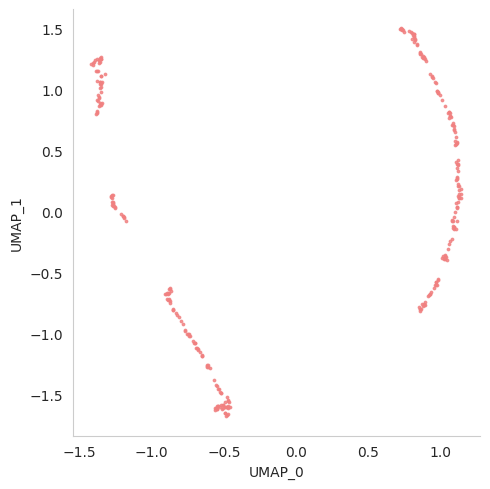

In [16]:
np.random.seed(42)
umap_emb=feature_clustering(30,0.1,'euclidean',data,True)

### Feature-type Distributed Clustering (FDC)

In [17]:
cont_list = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']

ord_list = ['anaemia','diabetes','high_blood_pressure','sex','smoking']

nom_list = None

target = ['DEATH_EVENT']


In [18]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/HeartFailure.json")

In [19]:
import json

features = {
    "cont_list": cont_list,
    "nom_list": nom_list,
    "ord_list": ord_list,
    "target": target
}

with open(output_file_path, "w") as json_file:
    json.dump(features, json_file)

FDC.normalize (init): 0.00001 / 0.000s


FDC.normalize (clustering CONT): 0.97407 / 0.974s


FDC.normalize (clustering ORD): 2.46024 / 3.434s
FDC.normalize (clustering NOM): 0.00006 / 3.434s
FDC.normalize (concat): 0.00002 / 3.434s


FDC.normalize (umap 5 -> 2): 1.07814 / 4.513s
FDC.normalize (array -> DataFrame): 0.00029 / 4.513s


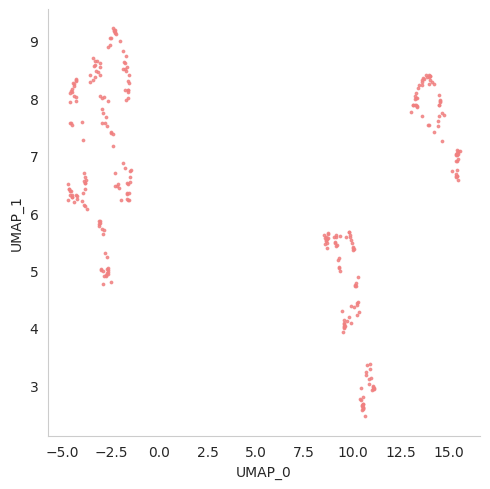

FDC.normalize (plotting): 0.42537 / 4.938s
FDC.normalize (array -> DataFrame): 0.00019 / 4.938s
FDC.normalize (total): 0.00001 / 4.938s


In [20]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)

fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, ordinal=ord_list)

FDC_emb_high,FDC_emb_low = fdc.normalize(data,cont_list=cont_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

### Clustering using K-means

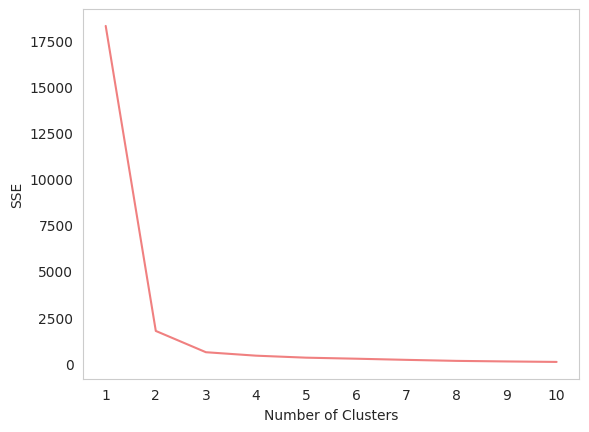

In [21]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(FDC_emb_low)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [22]:
def find_optimal_cluster(FDC_emb_low):
    silhouette_scores = []

    for n_clusters in list(range(2, 9)):
        km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)

        km.fit(FDC_emb_low)

        labels = km.labels_

        # Compute the silhouette score
        silhouette_avg = silhouette_score(FDC_emb_low, labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

In [23]:
find_optimal_cluster(FDC_emb_low)

[0.8093839,
 0.7952037,
 0.6016418,
 0.57500845,
 0.60027826,
 0.5727354,
 0.57474554]

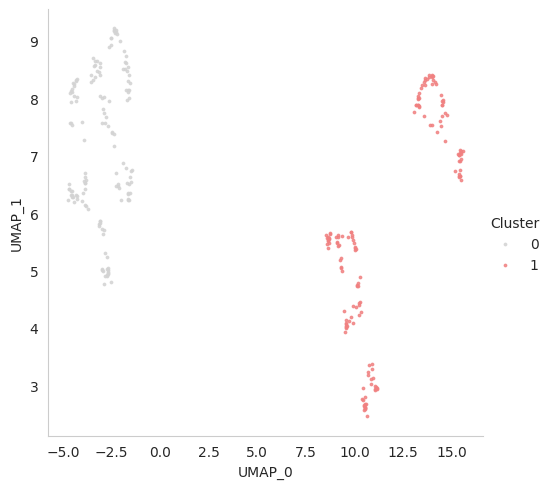

In [24]:
from fdc.clustering import *
np.random.seed(42)
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(2)

In [25]:
cluster_counts

array([146, 153])

In [26]:
data['Target']=cluster_list

In [27]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/SSHeartFailure.csv")
data.to_csv(output_file_path, index=False)

In [28]:
data

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking,Target
281,66.0,72,40,242000.0,1.2,134,121,1,0,1,1,0,0
265,63.0,103,35,179000.0,0.9,136,270,1,1,0,1,1,0
164,72.0,211,25,274000.0,1.2,134,207,0,0,0,0,0,1
9,50.0,115,20,189000.0,0.8,139,146,1,0,0,1,0,0
77,42.0,250,15,213000.0,1.3,136,65,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,50.0,318,40,216000.0,2.3,131,60,0,0,1,0,0,0
71,65.0,56,25,237000.0,5.0,130,207,0,0,0,0,0,0
106,70.0,125,25,237000.0,1.0,140,15,1,0,1,0,0,0
270,68.0,577,25,166000.0,1.0,138,43,1,0,1,1,0,0
